<a href="https://colab.research.google.com/github/Bufei2022/Anomaly-Detection/blob/main/Appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection in streaming time series data

## Outline 

1. Data Description, Evaluation Benchmark and Methods
2. Data Preprocessing
3. Statistical Hypothesis Based Anomaly Detection
4. GRU Based Anomaly Detection

## 1. Data Description, Evaluation Benchmark and Methods

I used benchmark data sets containing anomalies the [Yahoo data set](https://yahooresearch.tumblr.com/post/114590420346/a-benchmark-dataset-for-time-series-anomaly?fbclid=IwAR31SaUo48kFzUCeYPFDfVGRKyqYPW3vmY0XDuci7uIYM-XrrW86QXGerrY). This data set is provided as part of the Yahoo! Webscope program, to be used for approved non-commericial research proposed by recipients who have assigned a Data Sharing Agreement with Yahoo!. It contains `A1` to `A4` four benchmarks, with `A1` containing real traffic data from Yahoo servers, `A2/A3` containing synthetic data, and `A4` containing change points, which is outside the scope of this project. All benchmarks contain anomalies marked by humans. I will provide precision, recall, and F1 score for algorithms using the Yahoo data set, ROC curve, and AUC if applicable.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 1.1 Yahoo Webscope data set

I choose one data set from `A1 benchmark` and label it as `dat_real`. Details of the data set is given below.

In [ ]:
dat_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1439 non-null   int64  
 1   value       1439 non-null   float64
 2   is_anomaly  1439 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 33.9 KB


In [ ]:
dat_real[dat_real.is_anomaly==1]

,timestamp,value,is_anomaly
1431,1432,21.905100,1
1432,1433,18.535302,1
1433,1434,21.679476,1
1434,1435,23.526565,1
1435,1436,20.647311,1
1436,1437,22.200326,1
1437,1438,21.704851,1
1438,1439,22.575661,1


Visualization of the two Yahoo data sets. The red points are anomaly points labeled by human.

In [ ]:
from plotnine import *

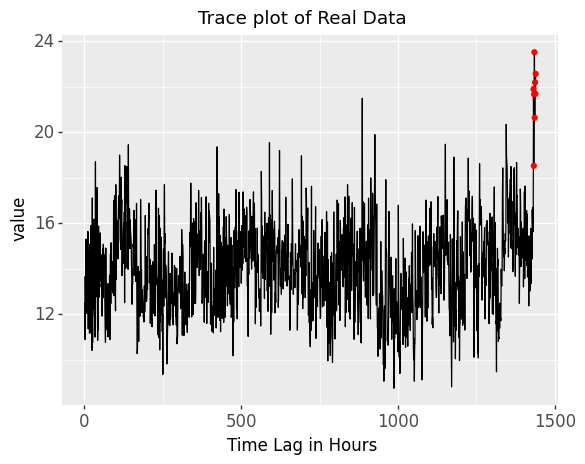

<ggplot: (8787946047476)>

In [ ]:
ggplot() +\
geom_line(aes(x='timestamp', y='value'), data=dat_real) +\
geom_point(aes(x='timestamp', y='value'), data=dat_real[dat_real.is_anomaly==1], color='red') +\
xlab('Time Lag in Hours') +\
ggtitle('Trace plot of Real Data') +\
theme(axis_text=element_text(size=12), axis_title=element_text(size=12)) 

## 2. Data Preprocessing

### Using Lagged Observations as Features
Time series data is time-dependent, and we wish to detect anomalies utilizing prediction based on previous observations. We could treat previous $m$ step observations $x_1,\dots,x_m$ as covariates while we try to predict $x_{m+1}$. The following function `generate_time_lags` takes a time series and returns a DataFrame with `m_lag` observations. Notice that the first `m_lag` observations are removed from the returned DataFrame as they do not have `m_lag` observations.

In [ ]:
def generate_time_lags(y_, m_lags):
  res = y_.copy()
  for m in range(1, m_lags+1):
    res[f"lag{m}"] = y_.shift(m)
  res = res.iloc[m_lags:]
  return res

### Dealing with Trend and Seasonal Effects

We need to remove trend and seasonal effects in statistics before fitting the time series models. This is usually done by using linear regression or smoothing/differencing. Also, if fit time series data to RNN, we need to count for the trend and seasonal effects in the model. 

I use two methods to include features that might affect the trend and seasonal effects of the time series data. One way is to treat them as categorical variables through one-hot encoding (regression through dummy variables). The `onehot_encode` function below takes a DataFrame and the column name(s) we want to encode and return an encoded DataFrame with the original column deleted.

Another way is to use trigonometrical polynomials. Let $d$ be the period and take $s = ⌊d/2⌋$. Model the cyclical features as sine and cosine transform of the given time feature $t$. i.e., $\sin(2\pi jt/d)$ and $\cos(2\pi jt/d)$, $j=1,\dots,s$. It also makes sense in deep learning models. As in one-hot encoding, the model does not know that hour 1 is closer to hour 2 than hour 6. Although if we give a complex enough deep learning model, it could also learn the cyclical features through one-hot encoding. The function `generate_cyclical_features` takes a DataFrame, variable name, period, and start timestamp as inputs. It returns DataFrame by replacing the original variable with a trigonometrical polynomial if `tri` is set to `True`. It can also perform feature converting by replacing a periodical variable with another periodical variable. For example, by setting `period=24`, it could convert hourly features to daily features. (hour 0 to hour 23 will all be considered as day 1).

In [ ]:
def onehot_encode(x_, col_names):
  for i in col_names:
    dummies = pd.get_dummies(x_[i], prefix=i)
    pd.concat([x_, dummies], axis=1).drop(columns=[i])
  return x_

def generate_cyclical_features(x_, col_name, period, start_num=0, tri=True, tar_name=None):
  if tri:
    s = int(np.floor(period/2))
    kwargs = dict()
    for j in range(1,s+1):
      kwargs[f'cos_{str(j)+col_name}'] = np.cos(2*np.pi*j*(x_[col_name]-start_num)/period)
      kwargs[f'sin_{str(j)+col_name}'] = np.sin(2*np.pi*j*(x_[col_name]-start_num)/period)
  else:
    kwargs = {
        f'{tar_name}' : lambda x: (x_[col_name]-start_num)//period
    }
  return x_.assign(**kwargs).drop(columns=[col_name])

### Splitting Data into Train, Validation, and Test Sets

We can train the model once using partial data and use the same model in anomaly detection or re-train/update the model at a given frequency as new data comes.

Since time series data are time-dependent, we must keep the time sequence intact when perfroming data splitting. It means we will not shuffle the data while splitting. The following function `train_val_test_split` performs unshuffled data splitting. If we already have a separate data set for testing, this function will only return training data and validation data with `test=False`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def train_val_test_split(x_, y_, test_ratio, test=False):
  if test:
    x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=test_ratio, shuffle=False)
    val_ratio = test_ratio/(1-test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio, shuffle=False)
    return x_train, x_val, x_test, y_train, y_val, y_test
  else:
    x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=test_ratio, shuffle=False)
    return x_train, x_val, y_train, y_val

Scaling the values in the data set before passing the data into the models. For convenience, I use a function to get the specific scaler I want to use.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

In [ ]:
def get_scaler(scaler):
  scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
  }
  return scalers.get(scaler.lower())()

### Find the Periodicity of Time Series
Some methods are sensitive to the periodicity specification. We can either use visualization to get an approximate estimation of periodicity or use autocorrelation function(acf) to find an estimation of periodicity. The following function takes a time series and calculates it's periodicity using acf.

In [ ]:
def find_period(ts):
    acf = np.correlate(ts, ts, 'full')[-len(ts):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return "The periodicity is " + str(peaks[acf[peaks].argmax()])

## 3. Statistical Hypothesis Based Anomaly Detection


### 3.1 Seasonal Hybrid Extreme Studentized Deviate(S-H-ESD) 

The S-H-ESD algorithm is an algorithm builds upon on the Generalized ESD test for detecting anomalies implemented at Twitter https://arxiv.org/pdf/1704.07706.pdf. This algorithm performs time series decomposition(filter trend and seasonal components) and uses robust statistical methods, i.e., median and median absolute deviation(MAD). We could use it for both global and local anomalies. For long time series, the algorithm employs piecewise approximation for anomaly detection. 

Descriptions of S-H-ESD algorithm are in the next subsection for those who are interested.

#### 3.1.1 S-H-ESD Algorithm

The ESD test requires an upper bound on the number of anomalies ($k$) to be specified. It computes the test statistic for the $k$ most extreme values, denoted as $x_{(1)}>\dots>x_{(k)}$, in the data set. Let $n$ be the total number of observations in the original time series. In the $j$th iteration, the test statistic is computed as
\begin{equation}
C_j=\frac{|x_{(j)}-\bar{x}|}{s},
\end{equation}
where $\bar{x}$ and $s$ denote the mean and variance of the current time series $X$. The test statistic is then compared with a critical value $\lambda_j$, where $\lambda_j$ is defined as
\begin{equation}
\lambda_j=\frac{(n-j)t_{p,n-j-1}}{\sqrt{(n-k-1+t^2_{p,n-j-1})(n-j+1)}},
\end{equation}

to determine whether a value is anomalous. Then we remove $x_{(j)}$ from the data set, recalculate the sample mean $\bar{x}$ and variance $s$, and update the critical value to $\lambda_{j+1}$. ESD repeats this process $k$ times, with the number of anomalies equal to the largest $m$ such that $C_m>\lambda_m$.

S-H-ESD algorithm further replace the mean $\bar{x}$ and variance $s$ by sample median absolute deviation 
\begin{equation}
MAD=median(|X_i-median_j(X_j)|)
\end{equation}
 and scaled sample median absolute deviation
\begin{equation}
\hat{σ}=b\cdot MAD
\end{equation}, where $b=1.4826$ for normally distributed data and $b=\frac{1}{Q(0.75)}$ for other distributions, with $Q(0.75)$ being the $0.75$th quantile.

#### 3.1.2 S-H-ESD implementation

The implementation of S-H-ESD is avaialble at an open-sourced R package [AnomalyDetection](https://github.com/twitter/AnomalyDetection). However, this R package is not submitted to CRAN and can only be downloaded from github, which might cause a problem under interfacing of colab and R. Instead, I use a Python package named `sesd`, which performs the same algorithm to do anomaly detection.

In [ ]:
!pip install sesd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sesd: filename=sesd-0.2-py3-none-any.whl size=4712 sha256=77a652a92473ef5b8a7045bcf251bf8f1c6db201a1996bd98db0bb2208eccc07
  Stored in directory: /root/.cache/pip/wheels/ff/e6/21/c6015da847eb21fdb4a04490febcf8fe91924de5eb9f5c76c2
Successfully built sesd


In [ ]:
import sesd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, auc

In [ ]:
def eval_metrics(y_, ypred_, alpha, cat=True):
  pred = np.zeros(len(y_))
  pred[ypred_] = 1
  if cat:
    precision, recall, f1, _ = precision_recall_fscore_support(y_, pred, average='binary', zero_division=0)
    print("The precioson, recall and f1 score is given by {}, {} and {} under {} sign. level".format(round(precision,3), round(recall,3), round(f1,3), alpha))
  else:
    tn, fp, fn, tp = confusion_matrix(y_, pred).ravel()
    return fp/(fp+tn), tp/(tp+fn)
  
  return

Find the periodicity of `dat_real` using function `find_period`. The periods for `dat_real` is estimated to be 5.

In [ ]:
find_period(dat_real.value)

'The periodicity is 5'

Under significance level $\alpha=0.05$ the precision, recall and f1 for `dat_real` is given by


In [ ]:
ESD_dat_real = sesd.seasonal_esd(dat_real.value, periodicity=5, hybrid=False, max_anomalies=20, alpha=0.05)
print("The indices for anomaly data points are", ESD_dat_real)
eval_metrics(dat_real.is_anomaly, ESD_dat_real, 0.05)

The indices for anomaly data points are [1438, 1437, 1431, 1436, 1433, 1434, 1435]
The precioson, recall and f1 score is given by 1.0, 0.875 and 0.933 under 0.05 sign. level


Under significance level $\alpha=0.01$ the precision, recall and f1 for `dat_real` is given by

In [ ]:
ESD_dat_real = sesd.seasonal_esd(dat_real.value, periodicity=5, hybrid=False, max_anomalies=20, alpha=0.01)
print("The indices for anomaly data points are", ESD_dat_real)
eval_metrics(dat_real.is_anomaly, ESD_dat_real, 0.01)

The indices for anomaly data points are [1438, 1437]
The precioson, recall and f1 score is given by 1.0, 0.25 and 0.4 under 0.01 sign. level


Plot the ROC curve and compute the AUC score for `dat_real`

In [ ]:
#Use significance level from 0.01 to 0.99, calculate false positive rate and true positive rate
alpha = np.linspace(0.01, 0.99, num=99)
ESD_real_tpr, ESD_real_fpr = [0]*99, [0]*99
for i in range(99):
  ESD_real_res = sesd.seasonal_esd(dat_real.value, periodicity=5, hybrid=False, max_anomalies=20, alpha=alpha[i])
  ESD_real_fpr[i], ESD_real_tpr[i] = eval_metrics(dat_real.is_anomaly, ESD_real_res, alpha[i], cat=False)

In [ ]:
#append an 1 to the end of false positive rate array and max true positive rate to the true positve rate array
#for computation of auc later
ESD_real_tpr = np.concatenate((ESD_real_tpr, np.array([max(ESD_real_tpr)])),axis=0)
ESD_real_fpr = np.concatenate((ESD_real_fpr, np.array([1])),axis=0)

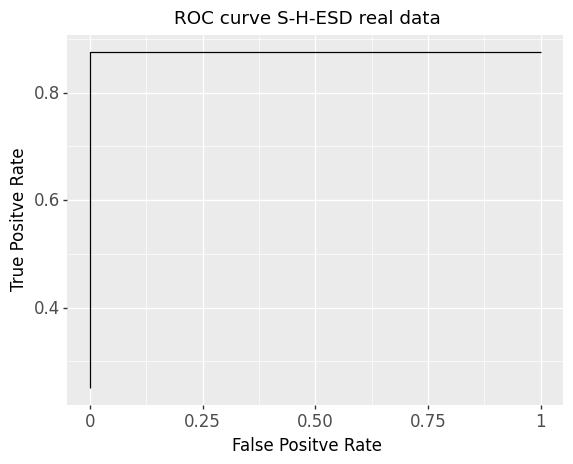

<ggplot: (8728122292845)>

In [ ]:
ggplot() +\
geom_line(aes(x=ESD_real_fpr, y=ESD_real_tpr)) +\
labs(x='False Positve Rate', y='True Positve Rate', title='ROC curve S-H-ESD real data') +\
theme(axis_text=element_text(size=12), axis_title=element_text(size=12))

The AUC for `dat_real` under S-H-ESD algorithm is $0.875$

In [ ]:
auc(ESD_real_fpr, ESD_real_tpr)

0.875

## 4. GRU Based Anomaly Detection

Import required packages. I use `DataLoader` and `TensorDataset` to help me with mini-batch training.

The GRU-based detector consists of two layers: a prediction layer and a decision layer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 4.1 GRU Based Detector: Prediction layer

 

The prediction layer contains a single/multi-layer GRU and an arbitrarily defined number of fully connected layer(s). People can tune the layers of GRU by changing the value of `num_layers`. If a multi-layer GRU is used, we can pass the results from the final(top) `last_num` number of layers to the fully connected layers. This makes the model more flexible when the time series data is complex, i.e., it contains multiple seasonal effects with different periodicities. Also, by including results from multiple layers of GRU, we hope the model could capture different levels of features in the data. The model passes results from the output layer of GRU to the fully connected layer by default; it can also pass results from hidden layer(s) of GRU to the fully connected layer if `hide=True`.

A dynamic sequential function is included to make adding new fully connected layers more convenient. The parameter `fc_sizes` contains the number of expected features in input for each fully connected layer after the first fully connected layer. i.e., the number of input features for $i$th fully connected layer after the first fully connected layer will be `fc_sizes[i-1]`. And the number of input features for the first fully connected layer will be `rnn_size*last_num` if `hide=True` and `rnn_size` if `hide=False`.

The class `gru` takes the following inputs:

1. `input_size`: the number of expected features in the input x
2. `rnn_size`: the number of features in the hidden state h
3. `fc_sizes`: number of features of fully connected layer per output layers of GRU. For example, `hide=True`, `fc_sizes`=$[4,3,2]$ and `last_num`=$2$ means we will have four fully connected layers with input size `rnn_size`$\times 2$, $4$, $3$ and $2$
4. `num_layers`: number of recurrent layers
5. `ouput_size`: Number of expected features in the output y
6. `dropout`: if not zero, induce a dropout layer on the outputs of each GRU layer
7. `last_num`: number of top hidden layers passed to fully connected layer, it must be smaller than or equal to `num_layers` and used when `hide=True`
8. `hide`: if the hidden layer results are passed or output layer results are passed to fully connected layer

In [ ]:
class gru(nn.Module):
  def __init__(self, input_size, rnn_size, fc_sizes, num_layers, output_size, dropout=0, last_num=1, hide=False):
    super().__init__()

    #Define GRU 
    self.rnn = nn.GRU(input_size=input_size,
                      hidden_size=rnn_size,
                      num_layers=num_layers,
                      dropout=dropout,
                      batch_first=True)
    
    #Define the how many top layers' output we want
    self.last_num = last_num if hide else 1

    #Define the input and output size for fully connected layers 
    self.fc_sizes = [rnn_size*self.last_num] + fc_sizes

    fc_blocks = [[nn.Linear(in_f, out_f), nn.ReLU()] for in_f, out_f in zip(self.fc_sizes, self.fc_sizes[1:])]
    fc_blocks = [item for sublist in fc_blocks for item in sublist]

    self.fc = nn.Sequential(*fc_blocks,
                            nn.Linear(fc_sizes[-1], output_size))
    
    #Define the dropout rate
    self.dropout = nn.Dropout(dropout)

    self.hide = hide
  def forward(self, input_seq):

    output, hidden = self.rnn(input_seq)

    #if hidden=True we will pass results from hidden layer to fc, otherwise pass results from output layers
    #We can choose how many layers output we want to pass to fc if we pass result from hidden layers of 
    #a multi-layer GRU
    if self.hide:
      output = self.dropout(torch.cat([hidden[-i,:,:] for i in range(1,self.last_num+1)], dim=1))
    else:
      output = self.dropout(output[:,-1,:])

    return self.fc(output)

Here is an example of the predictor layer, with `input_size=10`, `rnn_size=8`, `fc_sizes=[5,3,2]`, `num_layers=4`, `output_sizes=1`, `dropout=0.3`, `last_num=2`, and `hidden=True`. We expect to have a predictor layer consists of a four layer GRU with input size $10$ and output size $16$(`rnn_size*last_num`), followed by four fully connected layers with input size $16$, $5$, $3$ and $2$, respectively.

In [ ]:
demo = gru(input_size=10, rnn_size=8, fc_sizes=[5,3,2], num_layers=4, output_size=1, dropout=0.3, last_num=2, hide=True)
demo

gru(
  (rnn): GRU(10, 8, num_layers=4, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

Define the training function with mini-batch training.

In [ ]:
def train(model, dataloader, optimizer, criterion, batch_size, input_size):
  epoch_loss = 0
  
  model.train()

  for x_, y_ in dataloader:

    optimizer.zero_grad()

    x_ = x_.view([batch_size, -1, input_size]).to(device)
    y_ = y_.to(device)

    pred = model(x_)

    loss = criterion(pred, y_)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
  
  return epoch_loss/len(dataloader)

Define the evaluation function.

In [ ]:
def evaluate(model, dataloader, batch_size, input_size, criterion):

  model.eval()

  predictions, values, loss = [], [], 0

  with torch.no_grad():
    for x_, y_ in dataloader:

      x_ = x_.view([batch_size, -1, input_size]).to(device)
      y_ = y_.to(device)

      y_hat = model(x_)

      predictions.extend(y_hat.numpy())

      values.extend(y_.numpy())

      loss += criterion(y_hat, y_).item()

    return predictions, values, loss/len(dataloader)

### 4.2 GRU Based Detector: Decision layer

The anomaly classification will be based on how far our actual observations are from our predictions. We can either use a fixed threshold, or a dynamic threshold. When the distance between prediction and observation is above the prespecified threshold, we will declare an anomaly point been observed.


#### Rolling Gaussian Quantile Based Threshold

Some anomaly detection paper ([link](https://www.sciencedirect.com/science/article/pii/S0925231217309864)) proposd using anomaly likelihood based on (scaled) prediction error $s_t$ at timestep $t$. The anomaly likelihood is a probabilistic metric defining how anomalous the current state is based on the prediction history of the model. The distribuion is modeled as a rolling normal distribution where the sample mean, $\mu_t$, and variance, $\sigma^2_t$, are continuously updated from previous error values as follows:
\begin{equation}
\mu_t=\frac{\sum_{i=0}^{W-1}s_{t-i}}{W},
\end{equation}
and
\begin{equation}
\sigma_t^2=\frac{\sum_{i=0}^{W-1}(s_{t-i}-\mu_t)^2}{W-1}.
\end{equation}

Then compute a recent short term average of prediction errors, and apply a threshold to the Gaussian tail probability. Let $\Phi(\cdot)$ be the quantile for standard normal distribution, the anomaly likelihood is defined as
\begin{equation}
L_t=1-\Phi\left(\frac{\tilde{\mu}_t-\mu_t}{\sigma_t}\right),
\end{equation}

where $\tilde{\mu}_t=\frac{\sum_{i=0}^{W'-1}s_{t-i}}{W'}$. $W'$ is a window for a short term moving average, where $W'\ll W$. The threshold $L_t$ is based on a user-defined parameter $\alpha$ to report an anomaly:
\begin{equation}
\text{anomaly detected}≡ L_t\leq \alpha.
\end{equation}

This paper states that in practice, the system is not sensitive to $W$ as long as it is large enough to compute a reliable distribution. They use a generous value of $W=8000$, and $W'=10$. It also suggests an $\alpha=10^{-5}$, which is equivalent to choose an $\alpha=0.01$ with Bonferonni correction of $1000$, i.e. $0.01/1000=10^{-5}$. As this was a multiple test problem(we test for multiple points for anomaly), we need to adjust the significance level accordingly.

In [ ]:
import scipy.stats as sps

In [ ]:
def gaussian_tail(y_test, y_hat, train_err, quantile=0.95, large_error_lag=8000, small_error_lag=10, alpha=0.01, bonfer=1000):
  
  train_size = len(train_err)
  #set start and end index for moving window W and W'
  large_index_start = 0 if train_size<large_error_lag else train_size - large_error_lag
  large_index_end = train_size - 1
  large_index_size = large_index_end - large_index_start
  small_index_start = 0 if train_size<small_error_lag else train_size - small_error_lag
  small_index_end = train_size
  small_index_size = small_index_end - small_index_start

  #Combine the training error and testing error for easy updating
  #of rolling gaussian parameters, but the anomalies will be 
  #detected in a streaming manner(won't use future information
  #for currrent estimation)
  err = np.concatenate((train_err, y_test-y_hat), axis=0)
  anomaly = []

  for i in range(len(y_test)):
    resid = err[i+train_size]
    #Calculate mean and sd for error in large moving window
    mu_t, sigma_t = np.mean(err[large_index_start:large_index_end]), np.std(err[large_index_start:large_index_end])
    
    #Calculate mean for error in small moving window
    mu_hat = np.mean(err[small_index_start:small_index_end])

    #Compute test statistic
    z_score = abs(mu_hat-mu_t)/sigma_t

    #Compute critical value for the test
    norm_dist = sps.norm(loc=0, scale=1)
    critical_value = norm_dist.ppf(1-alpha/bonfer)

    #If test statistics is greater than critical value
    #declare anomaly
    if z_score>critical_value:
      anomaly.append(i)
    
    #print(z_score, critical_value) 
    #Update start and end index for moving windows
    if large_index_size<large_error_lag:
      large_index_end += 1
      large_index_size += 1
    else:
      large_index_start += 1
      large_index_end += 1

    if small_index_size<small_error_lag:
      small_index_end += 1
      small_index_size += 1
    else:
      small_index_start += 1
      small_index_end += 1

  return anomaly


#### Nonexchangable Conformal Prediction Based Threshold



In [ ]:
def conformal(y_test, y_hat, train_err, lag, weights=None, alpha=0.05, bonfer=True):
  
  #Use inverse lag as weight by default
  if not weights:
    #weights for delta_Ri
    weights = 1/np.array(range(1,lag+1))[: : -1]
  
  train_size = len(train_err)
  
  #set start and end index for moving window of size lag
  window_start = 0 if train_size<lag else train_size - lag
  window_end = train_size - 1
  window_size = window_end - window_start

  #Combine the training error and testing error for easy updating
  #of comformal predictions, but the anomalies will be 
  #detected in a streaming manner(won't use future information
  #for currrent estimation)
  err = np.concatenate((abs(train_err), abs(y_test-y_hat)), axis=0)
  anomaly = []

  for i in range(len(y_test)):

    curr_weights = weights[:window_size]
    #weights for delta_inf
    curr_weights = np.insert(curr_weights, 0, 1)

    #normalize weights
    curr_weights = curr_weights/np.sum(curr_weights)
    #calculate weighted quantile
    quan = np.cumsum(curr_weights)[1:]

    #index for critical value
    if bonfer:
      idx = np.argmax(quan>(1-alpha/lag))
    else:
      idx = np.argmax(quan>(1-alpha))
    #Calculate confidence interval for prediction
    critical_val = sorted(err[window_start:window_end])[idx]
    if y_test[i]<y_hat[i]-critical_val or y_test[i]>y_hat[i]+critical_val:
      anomaly.append(i)
      
    if window_size<lag:
      window_end += 1
      window_size += 1
    else:
      window_start += 1
      window_end += 1
    
  return anomaly

### 4.3 Continuous Online Learning from Streaming Data

The time series data is presented to the GRU-based anomaly detection algorithm in a continuous streaming scenario. When we split the data for training and detection, we will keep the original order of the data by not shuffling it while passing it to `DataLoader` function. 

The GRU model can either be trained once using the training data and kept unchanged while performing anomaly detection algorithm for the rest of the data. Or can be updated as new data comes. I used an online GRU, where the GRU model is updated every time a new data point is observed and retrained using backpropagation through time over the last 100 elements. It can also be updated at regular interval on a buffered data set of the previous time steps. However, given the size of our data set is relatively small, we will not use the last two methods in this project.

#### GRU Based Anomaly Detection: Real Time Series Data

The time series in this project only contains ``normal" data at the first $25\%$ of the data sets. We can train the GRU model using the first $25\%$ of the data and using this GRU model to predict the rest of the data.

In [ ]:
#Generate lagged observation, choose lag of 24 for dat_real
x_train = generate_time_lags(dat_real[['value']], 24)
y_train = dat_real[['value']].iloc[24:]
y_train.reset_index(drop=True, inplace=True)

In [ ]:
#Split train and test data
#the data is splitted without shuffling and first 25% is training data
x_train, x_test, y_train, y_test = train_val_test_split(x_train, y_train, 0.75)

In [ ]:
#record index for testing data
test_index = np.array(x_test.index)

In [ ]:
#Scaling the data
scaler_x = get_scaler('standard')
scaler_y = get_scaler('standard')
tar = [f'lag{i}' for i in range(1,24)]
x_train[tar] = scaler_x.fit_transform(x_train[tar])
x_test[tar] = scaler_x.transform(x_test[tar])
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [ ]:
#Transform to tensor and pass tp train_data and test_data
x_train = torch.from_numpy(np.array(x_train, dtype='float32'))
y_train = torch.from_numpy(np.array(y_train, dtype='float32'))
x_test = torch.from_numpy(np.array(x_test, dtype='float32'))
y_test = torch.from_numpy(np.array(y_test, dtype='float32'))

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

In [ ]:
batch_size = 2
input_size = 25
rnn_size = 128
fc_sizes = [64,32]
num_layers = 3
output_size = 1
dropout = 0.3
last_num = 2

model = gru(input_size, rnn_size, fc_sizes, num_layers, output_size, dropout, last_num, hide=False).to(device)

In [ ]:
model

gru(
  (rnn): GRU(25, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
train_data = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_data = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
n_epoches = 100

for epoch in range(n_epoches):
  train_loss = train(model, train_data, optimizer, criterion, batch_size, input_size)
  pre_, y_, val_loss = evaluate(model, test_data, batch_size, input_size, criterion)
  if epoch%10==0:
    print('train_loss {}'.format(train_loss))
    print('val_loss {}'.format(val_loss))

train_loss 0.9955439480148595
val_loss 1.0552120923201453
train_loss 0.2249109970494332
val_loss 0.41085460412415997
train_loss 0.14282981926821361
val_loss 0.2413059239258872
train_loss 0.12181426639207613
val_loss 0.22092950603093342
train_loss 0.08891239886460509
val_loss 0.2895478573209574
train_loss 0.07721159468664238
val_loss 0.15972213933571888
train_loss 0.08322447038848292
val_loss 0.291426489780525
train_loss 0.059983784731230116
val_loss 0.16506163780499686
train_loss 0.08000511334516473
val_loss 0.19695075691500924
train_loss 0.041020076980978294
val_loss 0.16875262713176417


plot time series predicted by our GRU model, where the balck line is the observation and red line is our prediction.

In [ ]:
y_ = np.array(y_).reshape((-1))
pre_ = np.array(pre_).reshape((-1))

real_org = pd.DataFrame({"timestamp":test_index, "value":y_, "data":'observation'})
real_pred = pd.DataFrame({"timestamp":test_index, "value":pre_, "data":'prediction'})
real_ = pd.concat((real_org, real_pred), axis=0)

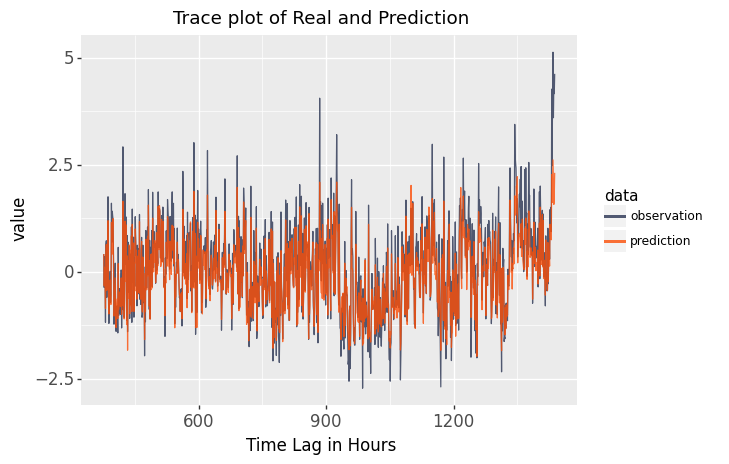

<ggplot: (8728116649301)>

In [ ]:
ggplot(real_)+\
geom_line(aes(x='timestamp', y='value', color='data'), alpha=0.8) +\
scale_color_manual(values = ("#293352", "#FC4E07")) +\
xlab('Time Lag in Hours') +\
ggtitle('Trace plot of Real and Prediction') +\
theme(axis_text=element_text(size=12), axis_title=element_text(size=12))

In [ ]:
y_hat, y_train, _ = evaluate(model, train_data, batch_size, input_size, criterion)

In [ ]:
y_hat = np.array(y_hat).reshape((-1))
y_train = np.array(y_train).reshape((-1))

Under significance level $\alpha=0.05$ and using a size $100$ large sliding window and size $1$ small sliding window with bonferroni correction the precision, recall and f1 for `dat_real` under rolling gaussian is given by

In [ ]:
gau_real = gaussian_tail(y_, pre_, y_train-y_hat, large_error_lag=100, small_error_lag=1, alpha=0.05, bonfer=200)+ test_index[0]
print("The indices for anomaly data points are", gau_real)
eval_metrics(dat_real.is_anomaly, gau_real, 0.05)

The indices for anomaly data points are [ 423  590  720  791  795  886 1151 1171 1345 1432 1434 1435 1437]
The precioson, recall and f1 score is given by 0.308, 0.5 and 0.381 under 0.05 sign. level


Under significance level $\alpha=0.01$ and using a size $100$ large sliding window and size $1$ small sliding window with bonferroni correction the precision, recall and f1 for `dat_real` under rolling gaussian is given by

In [ ]:
gau_real = gaussian_tail(y_, pre_, y_train-y_hat, large_error_lag=100, small_error_lag=1, alpha=0.01, bonfer=200)+ test_index[0]
print("The indices for anomaly data points are", gau_real)
eval_metrics(dat_real.is_anomaly, gau_real, 0.01)

The indices for anomaly data points are [ 423  590  720  886 1151 1345 1432 1434 1435 1437]
The precioson, recall and f1 score is given by 0.4, 0.5 and 0.444 under 0.01 sign. level


Under significance level $\alpha=0.05$ and using a $600$ sliding window with bonferroni correction the precision, recall and f1 for `dat_real` under conformal prediction is given by

In [ ]:
cp_real = conformal(y_, pre_ , y_train-y_hat, lag=600, weights=None, alpha=0.05) + test_index[0]
print("The indices for anomaly data points are", cp_real)
eval_metrics(dat_real.is_anomaly, cp_real, 0.05)

The indices for anomaly data points are [ 422  885 1431 1433 1434 1436]
The precioson, recall and f1 score is given by 0.667, 0.5 and 0.571 under 0.05 sign. level


Under significance level $\alpha=0.01$ and using a $600$ sliding window the precision, recall and f1 for `dat_real` under conformal prediction is given by

In [ ]:
cp_real = conformal(y_, pre_ , y_train-y_hat, lag= 600, weights=None, alpha=0.01) + test_index[0]
print("The indices for anomaly data points are", cp_real)
eval_metrics(dat_real.is_anomaly, cp_real, 0.01)

The indices for anomaly data points are [ 422  885 1431 1433 1434 1436]
The precioson, recall and f1 score is given by 0.667, 0.5 and 0.571 under 0.01 sign. level
